<a href="https://colab.research.google.com/github/JibeyJB/Projet-DATA/blob/main/Projet_DATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jean-Baptiste Attié
Yahya Kali
Vincent Karakoseian

**Projet** : Prédire la courbe des taux zéros-coupons des govies américaines par machine learning.

**1) Résumé du projet et motivations**

L’objectif de ce projet est de reconstruire (modéliser) la courbe des taux zéro-coupon des obligations souveraines américaines à l’aide de méthodes de machine learning, plutôt que d’utiliser exclusivement des modèles de taux classiques (Hull–White 1 facteur, 2 facteurs, etc.) qui sont souvent coûteux en calibration et sensibles aux hypothèses paramétriques.

Concrètement, on veut prédire certaines maturités de taux zéro-coupon (ici ZC_1Y, ZC_5Y, ZC_10Y) à partir d’un ensemble de variables macro-financières, de marché et internationales. Le code ci-dessous met en place la construction d’un dataset propre, homogène et aligné temporellement, étape indispensable avant tout entraînement ML : collecte, nettoyage, mise en fréquence mensuelle, alignement des dates, puis fusion de toutes les séries dans un seul fichier Excel final.

**2) Logique générale du code**

La partie 0 du script suit une logique simple :

- Importer les librairies nécessaires (API, manipulation de séries temporelles, finance de marché, export).

- Télécharger des séries macro-financières via FRED (Federal Reserve Economic Data) avec l’API.

- Télécharger des séries de marché via Yahoo Finance (S&P 500 et Gold).

- Mettre toutes les séries au même format :

index/colonne date

fréquence mensuelle fin de mois

même représentation de date (string pour Excel, datetime pour les merges)

- Corriger des trous spécifiques (cas du Gold début 2000).

- Fusionner (merge) toutes les séries sur l’intersection des dates disponibles (inner join).

- Exporter un dataset final final_dataset.xlsx prêt pour l’analyse et la modélisation.



## 0- Construction du DATASET

In [23]:
import requests
import pandas as pd
from google.colab import files
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from functools import reduce
from io import StringIO
from google.colab import files as colab_files
from sklearn.metrics import mean_squared_error


!pip -q install yfinance openpyxl
!pip install pmdarima


Le code installe yfinance et openpyxl puis importe :

- requests : appels HTTP à l’API FRED

- pandas : structure DataFrame, resampling mensuel, merge

- yfinance : téléchargement des prix de marché (S&P 500, Gold)

- reduce : fusion successive d’une liste de DataFrames

- numpy : pour créer la colonne vide (placeholder)

- google.colab.files : téléchargement automatique du fichier Excel depuis Colab

Même si matplotlib/seaborn sont importés, ils ne sont pas utilisés dans la version actuelle (ils peuvent servir plus tard à visualiser les séries ou faire des contrôles de cohérence).

In [24]:
API_KEY = "b3b5c91c2889c6547a16641236381cac"
BASE_URL = "https://api.stlouisfed.org/fred/series/observations"
START_DATE = "2000-01-01"

- START_DATE fixe l’horizon d’étude : toutes les séries sont récupérées à partir de janvier 2000.

- FRED est utilisé car c’est une source standard en finance et macroéconomie, fiable et largement documentée.

In [25]:
# -----------------------------
# FRED fetch
# -----------------------------
def fetch_fred_series(series_id, start_date="2000-01-01", col_name=None):
    params = {
        "series_id": series_id,
        "api_key": API_KEY,
        "file_type": "json",
        "observation_start": start_date,
    }
    r = requests.get(BASE_URL, params=params)
    r.raise_for_status()

    df = pd.DataFrame(r.json()["observations"])
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    if col_name is None:
        col_name = series_id

    df = df[["date", "value"]].rename(columns={"value": col_name})
    return df.set_index("date").sort_index()

Fonction fetch_fred_series

Cette fonction :

- envoie une requête à FRED (requests.get)

- récupère le JSON

- convertit en DataFrame

- force :

date au format datetime

value en numérique (les valeurs non numériques deviennent NaN)

renomme la colonne value selon col_name

renvoie un DataFrame indexé par date

- Résultat : chaque série FRED est ramenée sous une forme homogène date -> valeur.

In [26]:
def ensure_date_column(df):
    # si l'index est datetime, on le remet en colonne date
    if "date" not in df.columns:
        if isinstance(df.index, pd.DatetimeIndex):
            df = df.reset_index().rename(columns={"index": "date"})
        elif "Date" in df.columns:
            df = df.rename(columns={"Date":"date"})
        elif "DATE" in df.columns:
            df = df.rename(columns={"DATE":"date"})
        else:
            # fallback: première colonne -> date si convertible
            first = df.columns[0]
            test = pd.to_datetime(df[first], errors="coerce")
            if test.notna().sum() > 0:
                df = df.rename(columns={first:"date"})
            else:
                raise ValueError(f"Impossible de trouver une date dans df. Colonnes={df.columns.tolist()}")

    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"])
    return df

Fonction ensure_date_column

Cette fonction est un “pare-chocs” de robustesse : selon la source, la date peut être :

- un index datetime

- une colonne Date

- une colonne DATE

- ou même une première colonne non nommée

- La fonction garantit que :

la DataFrame contient une colonne date

qu'elle est convertible en datetime

les lignes sans date valide sont supprimées

- Cette étape évite les erreurs du type KeyError: 'date' au moment du merge.

Rôle des variables (justification économique)

Le dataset final contient des variables explicatives (features X) et des variables cibles (targets y).

Variables cibles : taux zéro-coupon US

Les colonnes suivantes sont explicitement les séries à modéliser :

- ZC_1Y : taux zéro-coupon US 1 an

- ZC_5Y : taux zéro-coupon US 5 ans

- ZC_10Y : taux zéro-coupon US 10 ans

Ces séries représentent directement des points de la courbe des taux, donc elles correspondent naturellement à la sortie du modèle ML.

Variables explicatives : politique monétaire US

- FEDFUNDS : taux directeur (Federal Funds Rate).
C’est l’ancre du taux court et un déterminant majeur de la courbe (surtout partie courte et intermédiaire).

- SPREAD_10Y2Y (T10Y2Y) : spread 10 ans – 2 ans.
Captures la pente de la courbe, très utilisé comme indicateur d’anticipations macro (récession, ralentissement, politique monétaire future).

Variables explicatives : Inflation expectations
- T5YIE (INF_EXP_5Y)

Intuition : c’est une mesure de l’inflation anticipée à horizon 5 ans (souvent interprétée comme un “break-even inflation” 5Y).

Pourquoi c’est mieux que CPI seul : CPI = inflation passée, T5YIE = inflation attendue par le marché.

Rôle ML : sépare mieux taux nominal vs composante inflation, donc aide à modéliser le niveau des ZC surtout sur maturités intermédiaires.

- T10YIE (INF_EXP_10Y)

Intuition : inflation anticipée long terme. Donne une info sur les régimes de crédibilité de la banque centrale et les anticipations de long terme.

Rôle ML : utile pour ZC_10Y et maturités plus longues, car la composante “long-run inflation” pèse davantage.

Volatility / Risk sentiment
- VIXCLS (VIX)

Intuition : proxy standard du stress de marché / aversion au risque.

Lien aux taux : en période risk-off, on observe souvent des flux vers Treasuries (safe haven) → pression à la baisse sur certains segments, variations de pente, convexité, etc.

Rôle ML : capture des mouvements de taux liés au sentiment, pas seulement aux fondamentaux macro.

Credit / Stress
- BAA10Y (spread corporate proxy)

Intuition : reflète les conditions de crédit / risque de défaut perçu / prime de risque.

Lien aux taux : quand les spreads de crédit s’écartent (stress), la demande de sûreté augmente et la politique monétaire anticipée change → impact sur niveau/pente.

Rôle ML : ajoute un facteur “conditions financières” complémentaire à VIX (VIX = volatilité actions, BAA10Y = stress crédit).

- TEDRATE (TED)

Intuition : mesure de stress sur le financement interbancaire (risque bancaire/liquidité). Historiquement très pertinent (crises).

Lien aux taux : stress funding → déplacement des primes de liquidité et de risque, changement de forme de courbe.

Rôle ML : capte des épisodes de crise que CPI/GDP ne captent pas à fréquence mensuelle.

Variables explicatives : inflation et activité

- CPIAUCSL : indice des prix à la consommation (CPI, inflation réalisée).
L’inflation est un déterminant des taux nominaux, et influence directement les anticipations de taux réels/nominal.

- GDP : produit intérieur brut (PIB).
Proxy du cycle économique : croissance plus forte, donc pression sur taux/anticipations.
Particularité : série trimestrielle ; on la transforme en mensuel puis on fait un forward-fill pour propager la dernière observation connue sur les mois intermédiaires (cohérent avec l’information disponible à date).

Variables explicatives : facteurs internationaux

Le choix d’inclure des taux étrangers répond à l’idée que la courbe US est influencée par :

- l'arbitrage international des taux,

- les flux de capitaux,

- les corrélations globales de politique monétaire.

Les séries :

- UK_RATE : taux monétaire UK (proxy de conditions monétaires UK)

- JP_RATE : taux monétaire Japon (important car régime structurel de taux bas, impact sur carry/global flows)

- CN_RATE : taux Chine (proxy conditions monétaires d’une grande économie mondiale)

Même si ces séries ne “déterminent” pas mécaniquement la courbe US, elles apportent une information utile sur le régime global de taux.

Variables de marché

- SP500 : niveau mensuel de l’indice S&P 500 (close mensuel).
Capture le régime risk-on/risk-off, les anticipations de croissance et le sentiment de marché. Très corrélé à certains mouvements de taux (via aversion au risque, perspective économique).

- GOLD : prix de l’or (close mensuel reconstruit depuis daily).
Proxy de stress, inflation fear, incertitude macro. Peut porter de l’information complémentaire sur les anticipations et régimes.

In [27]:
# -----------------------------
# Yahoo: GOLD (daily -> monthly) + manual patch
# -----------------------------
print("Téléchargement Yahoo GOLD …")
gold_d = yf.download(
    "GC=F",
    start=START_DATE,
    interval="1d",
    auto_adjust=True,
    progress=False,
    group_by="column"
)

if isinstance(gold_d.columns, pd.MultiIndex):
    gold_d.columns = gold_d.columns.get_level_values(0)

gold_m = gold_d[["Close"]].rename(columns={"Close":"GOLD"})

gold_m = gold_m.reset_index().rename(columns={"Date":"date"})
gold_m = ensure_date_column(gold_m)

Téléchargement Yahoo GOLD …


In [28]:
# -----------------------------
# Yahoo: SP500 (monthly)
# -----------------------------
print("Téléchargement Yahoo SP500 …")
sp500 = yf.download(
    "^GSPC",
    start=START_DATE,
    interval="1d",
    auto_adjust=True,
    progress=False,
    group_by="column"
)

if isinstance(sp500.columns, pd.MultiIndex):
    sp500.columns = sp500.columns.get_level_values(0)

sp500 = sp500[["Close"]].rename(columns={"Close": "SP500"})
#sp500.index = sp500.index.to_period("M").to_timestamp("M")

sp500 = sp500.reset_index().rename(columns={"Date":"date"})
sp500 = ensure_date_column(sp500)
#sp500["date"] = sp500["date"].dt.strftime("%Y-%m-%d")


Téléchargement Yahoo SP500 …


In [29]:

# -----------------------------
# FRED series
# -----------------------------
series_dict = {
     # --- Policy & Macro US ---
    "FEDFUNDS":  "FEDFUNDS",
    "CPIAUCSL":  "CPIAUCSL",
    "GDP":       "GDP",
    "T10Y2Y":    "READ_10Y",

    # --- Inflation expectations ---
    "T5YIE":     "INF_EXP_5Y",
    "T10YIE":    "INF_EXP_10Y",

    # --- Volatility ---
    "VIXCLS":    "VIX",

    # --- Credit / stress ---
    "BAA10Y":    "BAA10Y",     # corporate spread proxy
    "TEDRATE":   "TED",        # TED spread

    # --- International rates ---
    "IRSTCI01GBM156N": "UK_RATE",
    "IRSTCB01JPM156N": "JP_RATE",
    "INTDSRCNM193N":   "CN_RATE",

    # --- Zero coupon targets ---
    "THREEFY1":  "ZC_1Y",
    "THREEFY5":  "ZC_5Y",
    "THREEFY10": "ZC_10Y",
    "THREEFY2":  "ZC_2Y",
    "THREEFY3":  "ZC_3Y",
    "THREEFY7":  "ZC_7Y",
}

fred_monthly_dfs = []

for fred_id, col_name in series_dict.items():
    print(f"Téléchargement FRED {fred_id} …")
    df = fetch_fred_series(fred_id, start_date=START_DATE, col_name=col_name)

    df_m = df.resample("B").ffill()

  #  if fred_id == "GDP" or "CN_RATE":
  #      df_m = df_m.ffill()

    df_m = df_m.reset_index() # -> colonne date
    df_m = ensure_date_column(df_m)

    # date string pour Excel clean
    #df_m["date"] = df_m["date"].dt.strftime("%Y-%m-%d")

    fred_monthly_dfs.append(df_m)

Téléchargement FRED FEDFUNDS …
Téléchargement FRED CPIAUCSL …
Téléchargement FRED GDP …
Téléchargement FRED T10Y2Y …
Téléchargement FRED T5YIE …
Téléchargement FRED T10YIE …
Téléchargement FRED VIXCLS …
Téléchargement FRED BAA10Y …
Téléchargement FRED TEDRATE …
Téléchargement FRED IRSTCI01GBM156N …
Téléchargement FRED IRSTCB01JPM156N …
Téléchargement FRED INTDSRCNM193N …
Téléchargement FRED THREEFY1 …
Téléchargement FRED THREEFY5 …
Téléchargement FRED THREEFY10 …
Téléchargement FRED THREEFY2 …
Téléchargement FRED THREEFY3 …
Téléchargement FRED THREEFY7 …


In [30]:

# -----------------------------
# MERGE FINAL (en mémoire)
# -----------------------------

dfs = [sp500, gold_m] + fred_monthly_dfs

# convertir date en datetime uniquement pour merge
dfs_dt = []
for df in dfs:
    dfx = df.copy()
    dfx["date"] = pd.to_datetime(dfx["date"], errors="coerce")
    dfx = dfx.dropna(subset=["date"])
    dfs_dt.append(dfx)

df_final = reduce(lambda left, right: pd.merge(left, right, on="date", how="inner"), dfs_dt)
df_final = df_final.sort_values("date").reset_index(drop=True)

# export (date string)
df_final_export = df_final.copy()
df_final_export["date"] = df_final_export["date"].dt.strftime("%Y-%m-%d")

out_path = "/content/final_dataset.xlsx"
df_final_export.to_excel(out_path, index=False)

print(df_final_export.head())
print(df_final_export.tail())
print(df_final_export.isna().sum())

colab_files.download(out_path)

         date       SP500        GOLD  FEDFUNDS  CPIAUCSL        GDP  \
0  2003-01-02  909.030029  346.100006      1.24     182.6  11174.129   
1  2003-01-03  908.590027  351.200012      1.24     182.6  11174.129   
2  2003-01-06  929.010010  351.700012      1.24     182.6  11174.129   
3  2003-01-07  922.929993  347.299988      1.24     182.6  11174.129   
4  2003-01-08  909.929993  353.899994      1.24     182.6  11174.129   

   READ_10Y  INF_EXP_5Y  INF_EXP_10Y    VIX  ...   TED  UK_RATE  JP_RATE  \
0      2.27        1.30         1.64  25.39  ...  0.18   3.8044      0.1   
1      2.26        1.28         1.62  24.68  ...  0.19   3.8044      0.1   
2      2.25        1.31         1.63  24.91  ...  0.20   3.8044      0.1   
3      2.27        1.28         1.62  25.13  ...  0.22   3.8044      0.1   
4      2.29        1.33         1.71  25.53  ...  0.21   3.8044      0.1   

   CN_RATE   ZC_1Y   ZC_5Y  ZC_10Y   ZC_2Y   ZC_3Y   ZC_7Y  
0      2.7  1.3662  3.0541  4.4274  1.7591  2.216

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## EDA

Vue d'ensemble du dataset

In [31]:
# PREP
df = df_final.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").set_index("date")

print(df.shape)
df.head()

(4784, 20)


,SP500,GOLD,FEDFUNDS,CPIAUCSL,GDP,READ_10Y,INF_EXP_5Y,INF_EXP_10Y,VIX,BAA10Y,TED,UK_RATE,JP_RATE,CN_RATE,ZC_1Y,ZC_5Y,ZC_10Y,ZC_2Y,ZC_3Y,ZC_7Y
date,,,,,,,,,,,,,,,,,,,,
2003-01-02,909.030029,346.100006,1.24,182.6,11174.129,2.27,1.30,1.64,25.39,3.37,0.18,3.8044,0.1,2.7,1.3662,3.0541,4.4274,1.7591,2.2167,3.7090
2003-01-03,908.590027,351.200012,1.24,182.6,11174.129,2.26,1.28,1.62,24.68,3.39,0.19,3.8044,0.1,2.7,1.3729,3.0807,4.4557,1.7760,2.2389,3.7369
2003-01-06,929.010010,351.700012,1.24,182.6,11174.129,2.25,1.31,1.63,24.91,3.38,0.20,3.8044,0.1,2.7,1.3956,3.1261,4.4981,1.8127,2.2816,3.7815
2003-01-07,922.929993,347.299988,1.24,182.6,11174.129,2.27,1.28,1.62,25.13,3.39,0.22,3.8044,0.1,2.7,1.3631,3.0926,4.4701,1.7770,2.2458,3.7505
2003-01-08,909.929993,353.899994,1.24,182.6,11174.129,2.29,1.33,1.71,25.53,3.35,0.21,3.8044,0.1,2.7,1.3363,3.0553,4.4358,1.7431,2.2091,3.7144


In [32]:
# VUE D’ENSEMBLE
print("Shape :", df.shape)
print("Période :", df.index.min().date(), "->", df.index.max().date())
print("Index unique :", df.index.is_unique)
print("Index trié   :", df.index.is_monotonic_increasing)

# trous dans la timeline (jours ouvrés)
b = pd.bdate_range(df.index.min(), df.index.max())
print("Jours ouvrés attendus :", len(b))
print("Jours ouvrés présents :", df.index.nunique())

Shape : (4784, 20)
Période : 2003-01-02 -> 2022-01-21
Index unique : True
Index trié   : True
Jours ouvrés attendus : 4972
Jours ouvrés présents : 4784


Valeurs manquantes

In [33]:
# VALEURS MANQUANTES
na = df.isna().sum().sort_values(ascending=False)
na_pct = (df.isna().mean()*100).sort_values(ascending=False)

print("Colonnes avec NA :")
print(pd.DataFrame({"NA": na, "%": na_pct}).query("NA > 0").head(30))

print("\nLignes complètes :", df.dropna().shape[0], "/", df.shape[0])
print("Lignes avec ≥1 NA :", df.shape[0] - df.dropna().shape[0])

Colonnes avec NA :
              NA         %
TED          119  2.487458
BAA10Y        36  0.752508
INF_EXP_5Y    34  0.710702
READ_10Y      34  0.710702
ZC_3Y         34  0.710702
ZC_7Y         34  0.710702
ZC_10Y        34  0.710702
ZC_5Y         34  0.710702
INF_EXP_10Y   34  0.710702
ZC_2Y         34  0.710702
ZC_1Y         34  0.710702
CN_RATE       20  0.418060

Lignes complètes : 4644 / 4784
Lignes avec ≥1 NA : 140


Target (ZC_1Y)

count    4750.000000
mean        1.372581
std         1.490483
min        -0.033200
25%         0.191950
50%         0.644700
75%         2.103200
max         5.237000
Name: ZC_1Y, dtype: float64


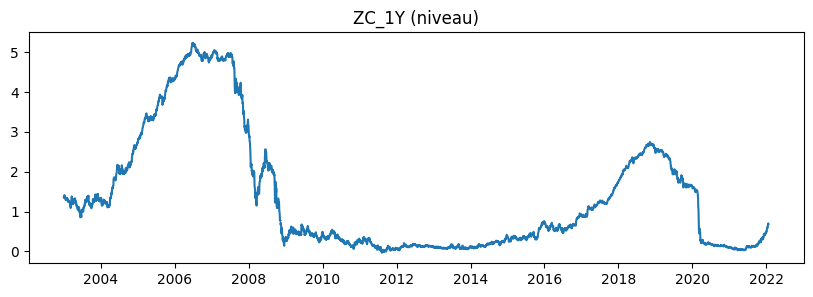

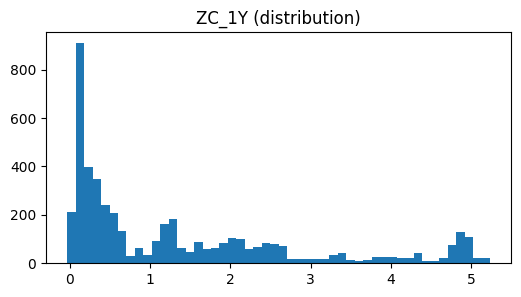

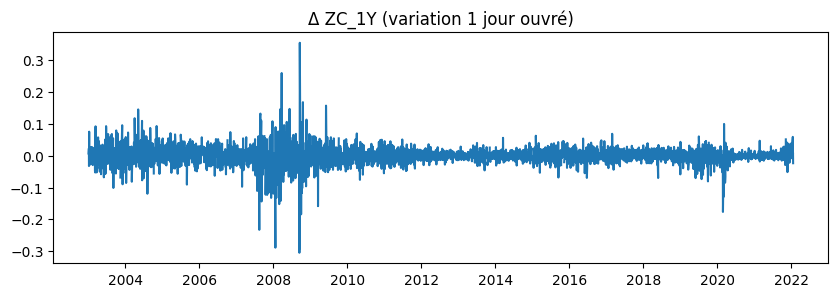

In [34]:
# TARGET : ZC_1Y
y = df["ZC_1Y"]

print(y.describe())

plt.figure(figsize=(10,3))
plt.plot(y.index, y)
plt.title("ZC_1Y (niveau)")
plt.show()

plt.figure(figsize=(6,3))
plt.hist(y.dropna(), bins=50)
plt.title("ZC_1Y (distribution)")
plt.show()

plt.figure(figsize=(10,3))
plt.plot(y.diff().index, y.diff())
plt.title("Δ ZC_1Y (variation 1 jour ouvré)")
plt.show()

Features clés

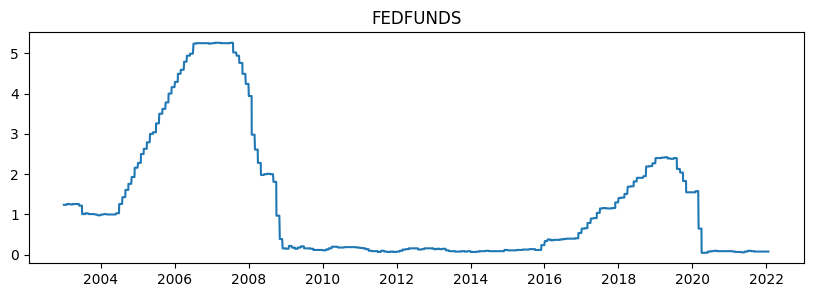

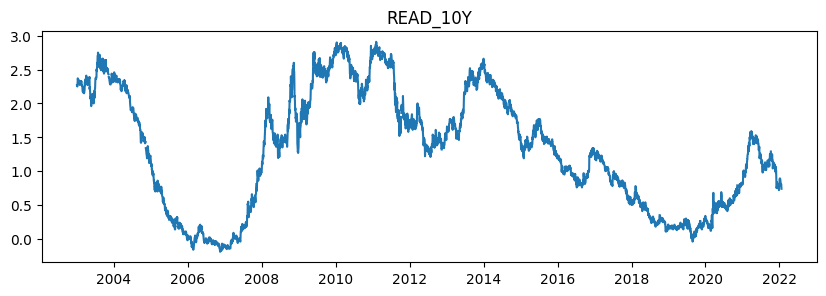

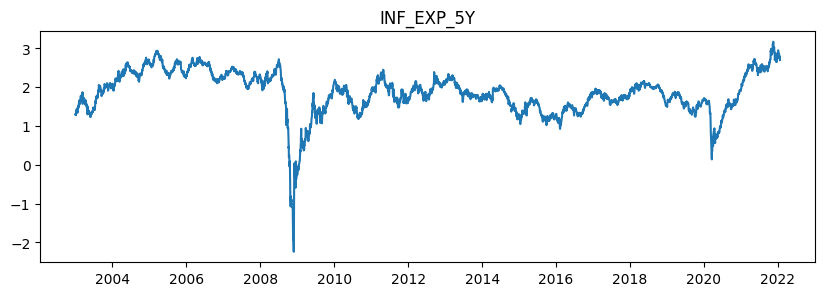

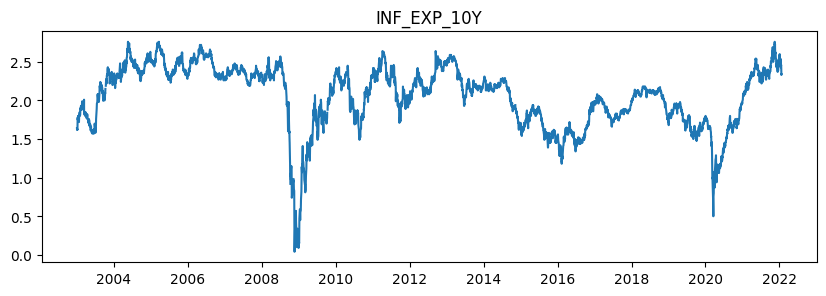

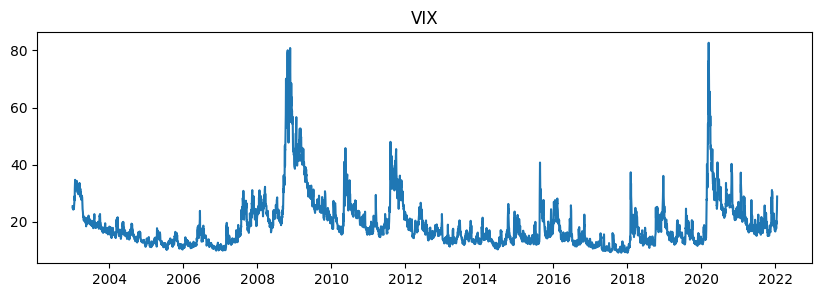

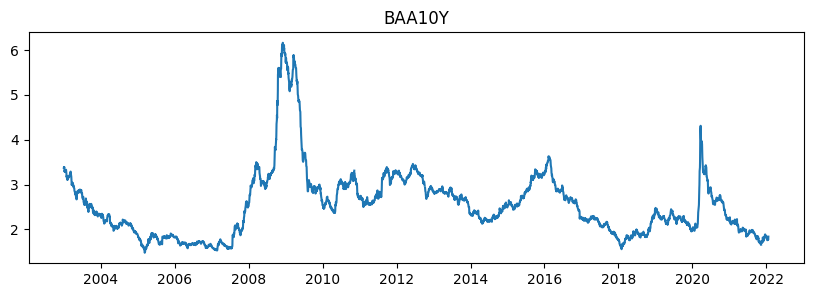

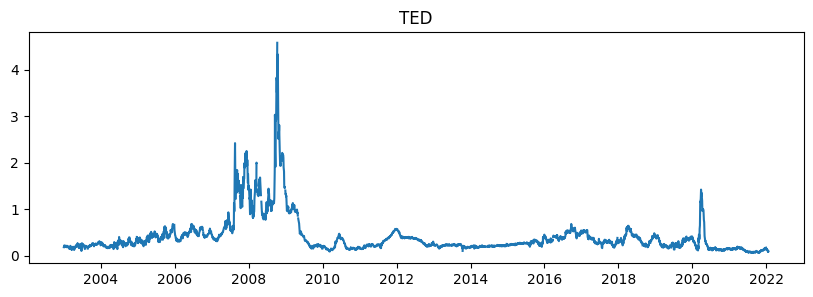

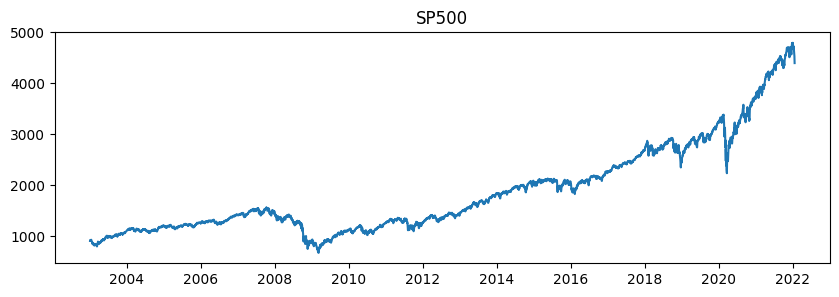

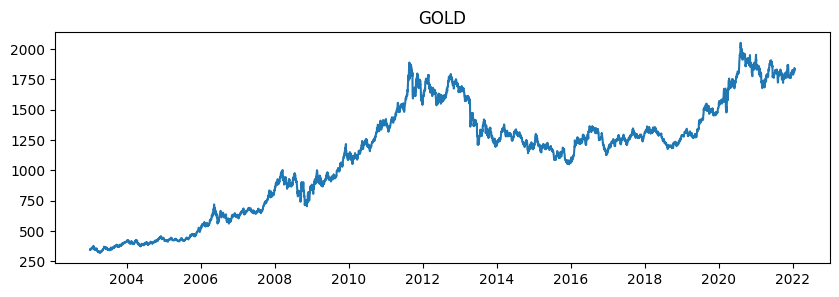

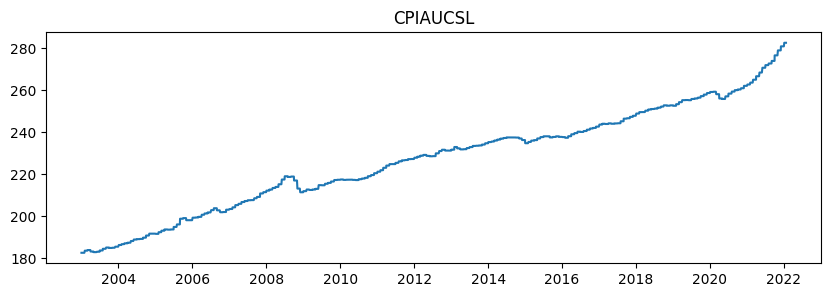

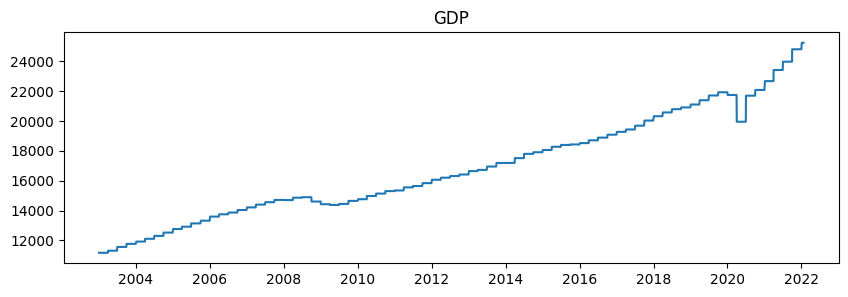

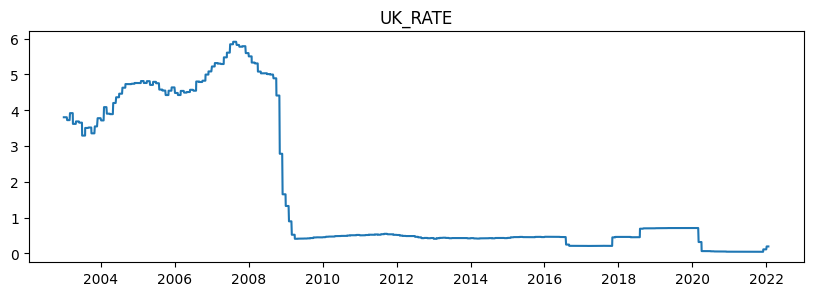

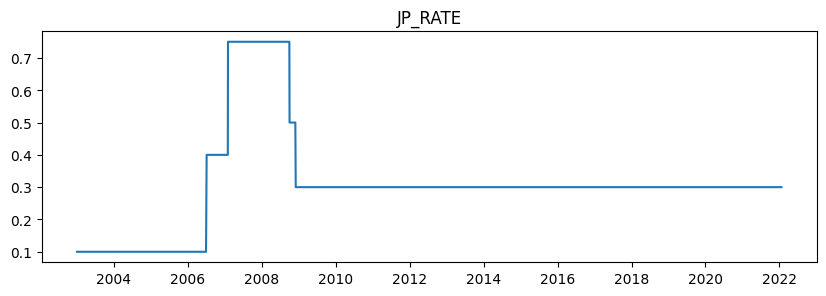

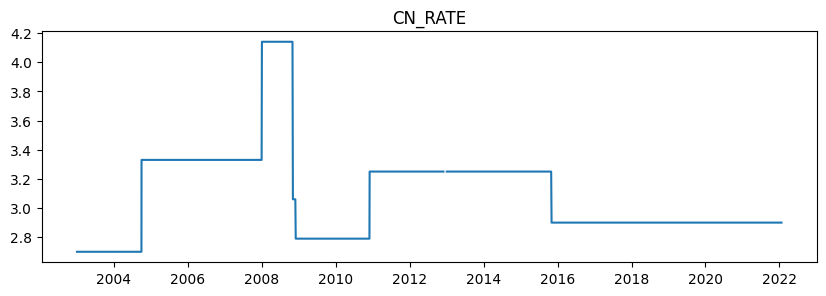

In [35]:
cols = ["FEDFUNDS","READ_10Y","INF_EXP_5Y","INF_EXP_10Y","VIX","BAA10Y","TED","SP500","GOLD","CPIAUCSL","GDP","UK_RATE","JP_RATE","CN_RATE"]
cols = [c for c in cols if c in df.columns]

for c in cols:
    plt.figure(figsize=(10,3))
    plt.plot(df.index, df[c])
    plt.title(c)
    plt.show()

Corrélations

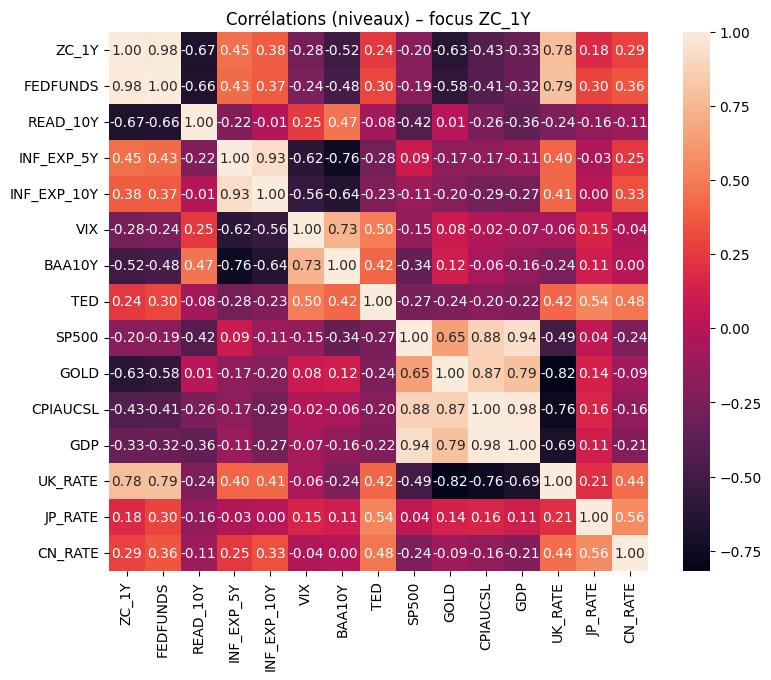

In [36]:
# RELATIONS : HEATMAP CORR (niveaux)
import seaborn as sns

cols = ["ZC_1Y","FEDFUNDS","READ_10Y","INF_EXP_5Y","INF_EXP_10Y","VIX","BAA10Y","TED","SP500","GOLD","CPIAUCSL","GDP","UK_RATE","JP_RATE","CN_RATE"]
cols = [c for c in cols if c in df.columns]

corr = df[cols].dropna().corr()

plt.figure(figsize=(9,7))
sns.heatmap(corr, annot=True, fmt=".2f", square=True)
plt.title("Corrélations (niveaux) – focus ZC_1Y")
plt.show()

## 1 -  OLS

Ici on trouve les coefficients de f avec Y1=f(variables) en supposant f linéaire.

Importer final_dataset dans le collab pour que ça fonctionne !

On entraine que sur 80% du dataset afin de d'avoir 20% (les plus récent) pour le test.

On enlève aussi la partie "Y" du dataset (les zéros coupons) qui en font pas partie des variables explicatives.

In [37]:

# 1) Charger le dataset

df = pd.read_excel("final_dataset.xlsx")
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date").sort_index()

# 2) Définir la cible

Y = df[["ZC_1Y"]]

# 3) Définir les variables explicatives
#    (on enlève TOUS les zéro-coupons)

zc_cols = ["ZC_1Y", "ZC_2Y", "ZC_3Y", "ZC_5Y", "ZC_7Y", "ZC_10Y"]
X = df.drop(columns=zc_cols)

# 4) Nettoyage

df_model = pd.concat([Y, X], axis=1).dropna()
Y = df_model[["ZC_1Y"]]
X = df_model.drop(columns=["ZC_1Y"])

# 5) Split temporel : 80% train uniquement

split = int(0.8 * len(df_model))
X_train = X.iloc[:split]
Y_train = Y.iloc[:split]

In [38]:
# 6) OLS (avec intercept)

X_mat = np.c_[np.ones(len(X_train)), X_train.to_numpy()]
Y_mat = Y_train.to_numpy()

B = np.linalg.pinv(X_mat.T @ X_mat) @ (X_mat.T @ Y_mat)

# 7) Coefficients lisibles

coef = pd.DataFrame(
    B,
    index=["Intercept"] + list(X_train.columns),
    columns=["ZC_1Y"]
)

print(coef)


                ZC_1Y
Intercept   -1.866415
SP500       -0.000644
GOLD        -0.001270
FEDFUNDS     0.639932
CPIAUCSL     0.021449
GDP          0.000029
READ_10Y    -0.433803
INF_EXP_5Y  -0.078712
INF_EXP_10Y  0.527760
VIX          0.011252
BAA10Y      -0.158163
TED         -0.020351
UK_RATE     -0.018708
JP_RATE     -0.324833
CN_RATE     -0.125278


In [39]:
# 8) Jeu de test (20% les plus récents)

X_test = X.iloc[split:]
Y_test = Y.iloc[split:]

# 9) Prédiction sur le test

X_test_mat = np.c_[np.ones(len(X_test)), X_test.to_numpy()]
Y_hat = X_test_mat @ B

Y_hat = pd.DataFrame(
    Y_hat,
    index=Y_test.index,
    columns=["ZC_1Y_pred"]
)


# 10) Métriques de test
error = Y_test["ZC_1Y"].values - Y_hat["ZC_1Y_pred"].values

rmse = np.sqrt(np.mean(error**2))

ss_res = np.sum(error**2)
ss_tot = np.sum((Y_test["ZC_1Y"] - Y_test["ZC_1Y"].mean())**2)
r2 = 1 - ss_res / ss_tot

print("Test RMSE:", rmse)
print("Test R2:", r2)


Test RMSE: 0.36667477458206904
Test R2: 0.87668050574335


C'est un bon résulat R2=0.88 pour une OLS. RMSE=0.37

88% de la variance de ZC1Y​ est expliquée par les variables explicatives.

Pas de relation causale.

Modèle fragile perfectible.

\begin{equation}
\begin{aligned}
ZC_{1Y,t} =\;&
-1.866415
-0.000644\,SP500_t
-0.001270\,GOLD_t
+0.639932\,FEDFUNDS_t
+0.021449\,CPIAUCSL_t \\
&+0.000029\,GDP_t
-0.433803\,READ_{10Y,t}
-0.078712\,INF\_EXP_{5Y,t}
+0.527760\,INF\_EXP_{10Y,t} \\
&+0.011252\,VIX_t
-0.158163\,BAA10Y_t
-0.020351\,TED_t
-0.018708\,UK\_RATE_t \\
&-0.324833\,JP\_RATE_t
-0.125278\,CN\_RATE_t
+ \varepsilon_t
\end{aligned}
\end{equation}

## 2 - ARIMA

In [40]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf


In [41]:

print("===================================")
print("ARIMA – Analyse sur ZC_1Y (train)")
print(f"Nombre d'observations (train) : {len(Y_train)}")
print("===================================\n")

# --------------------------
# 4) Test de stationnarité (ADF)
# --------------------------
adf_stat, p_value, _, _, crit_vals, _ = adfuller(Y_train)

print("TEST ADF (stationnarité)")
print("------------------------")
print(f"ADF statistic : {adf_stat:.4f}")
print(f"p-value       : {p_value:.4f}")
print("Valeurs critiques :")
for k, v in crit_vals.items():
    print(f"  {k} : {v:.4f}")

if p_value < 0.05:
    print("=> Série stationnaire (rejet H0)\n")
else:
    print("=> Série NON stationnaire (H0 non rejetée)\n")

# --------------------------
# 5) autoARIMA (choix p,d,q)
# --------------------------
model = auto_arima(
    Y_train,
    start_p=0, start_q=0,
    max_p=4, max_q=4,
    seasonal=False,
    information_criterion="aic",
    stepwise=True,
    suppress_warnings=True
)

print("AUTO ARIMA – Modèle sélectionné")
print("-------------------------------")
print(model.summary())
print(f"\nAIC du modèle sélectionné : {model.aic():.4f}\n")

# --------------------------
# 6) Résidus
# --------------------------
residuals = pd.Series(model.resid(), index=Y_train.index)

# --------------------------
# 7) Autocorrélation des résidus
# --------------------------
acf_vals = acf(residuals, nlags=10)

print("AUTOCORRÉLATION DES RÉSIDUS (ACF)")
print("--------------------------------")
for i, val in enumerate(acf_vals):
    print(f"Lag {i:2d} : {val:.4f}")
print()

# --------------------------
# 8) Test de Ljung–Box
# --------------------------
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)

print("TEST DE LJUNG–BOX (lag 10)")
print("--------------------------")
print(lb_test)

if lb_test["lb_pvalue"].values[0] > 0.05:
    print("\n=> Pas d'autocorrélation résiduelle (OK)")
else:
    print("\n=> Autocorrélation résiduelle détectée (modèle insuffisant)")


ARIMA – Analyse sur ZC_1Y (train)
Nombre d'observations (train) : 3715

TEST ADF (stationnarité)
------------------------
ADF statistic : -0.9686
p-value       : 0.7646
Valeurs critiques :
  1% : -3.4321
  5% : -2.8623
  10% : -2.5672
=> Série NON stationnaire (H0 non rejetée)

AUTO ARIMA – Modèle sélectionné
-------------------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3715
Model:               SARIMAX(0, 2, 3)   Log Likelihood                7774.322
Date:                Sun, 22 Feb 2026   AIC                         -15538.643
Time:                        20:45:28   BIC                         -15507.545
Sample:                             0   HQIC                        -15527.578
                               - 3715                                         
Covariance Type:                  opg                                         
                 coef    

<Figure size 640x480 with 0 Axes>

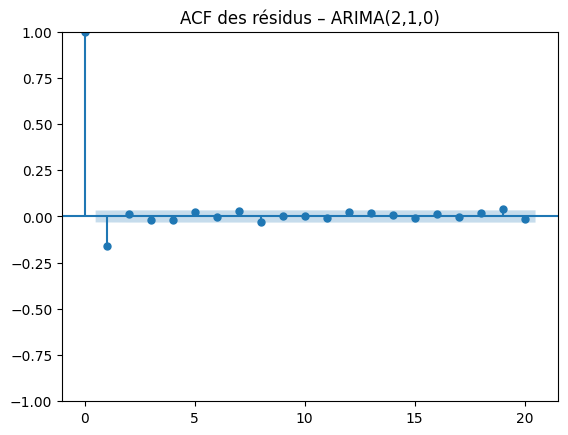

In [42]:
plt.figure()
plot_acf(residuals, lags=20)
plt.title("ACF des résidus – ARIMA(2,1,0)")
plt.show()

Non stationnaire d'après le test ADF : p-value = 0.756.

Modèle retenu ARIMA(2,2,1).

Présence d’autocorrélation résiduelle. Le modèle ne capture pas totalement la dépendance temporelle.

Normalité: Les résidus ne suivent pas une distribution normale.

La dynamique moyenne est partiellement capturée par un ARIMA(2,2,1) mais il ne modélise pas entièrement la structure de dépendance et la dynamique de variance de la série.
\vspace{\baselineskip}

\begin{equation}
\Delta^2 ZC_{1Y,t}
=
0.1970\,\Delta^2 ZC_{1Y,t-1}
-
0.0863\,\Delta^2 ZC_{1Y,t-2}
-
0.9892\,\varepsilon_{t-1}
+
\varepsilon_t
\end{equation}

\vspace{\baselineskip}

\begin{equation}
\Delta^2 ZC_{1Y,t}
=
(1 - B)^2 ZC_{1Y,t}
\end{equation}


Evaluation du modèle:

In [43]:
from sklearn.metrics import mean_squared_error
y_true = Y_test.squeeze().to_numpy()
y_pred = np.asarray(model.predict(n_periods=len(y_true)))


rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"RMSE (ARIMA) : {rmse:.6f}")

RMSE (ARIMA) : 3.415527


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


RMSE = 3.4

Le RMSE est très élevé au regard du niveau moyen du taux.
L’erreur moyenne dépasse la variance naturelle de la série, indiquant une incapacité du modèle à reproduire la dynamique hors échantillon.

C'était 0.37 pour l'OLS. 10 fois plus gros ici.
Le modèle n'est pas adapté.

C'est logique, il ne tient pas compte de toutes les variables. Mais uniquement des lags précédents de ZC_1Y.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


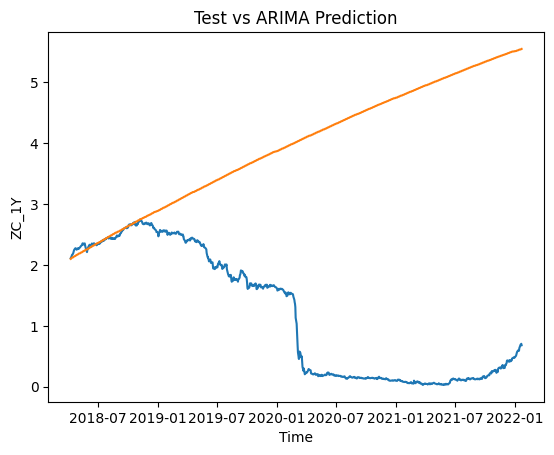

In [44]:

y_true = Y_test.squeeze().to_numpy()
y_pred = np.asarray(model.predict(n_periods=len(y_true)))
n = min(len(y_true), len(y_pred))
y_true = y_true[:n]
y_pred = y_pred[:n]
dates = Y_test.index[:n]
plt.figure()
plt.plot(dates, y_true)
plt.plot(dates, y_pred)
plt.xlabel("Time")
plt.ylabel("ZC_1Y")
plt.title("Test vs ARIMA Prediction")
plt.show()

On note également que le dataset de test a lieu sur la période Covid, ce qui biaise les résultats. On voit que jusqu'à 01-19, la prédiction était correcte.

On pourrait évaluer le test sur une autre période. Mais le modèle doit être capable de rester valable en cas de crise. Donc c'est une bonne chose.

Piste: Deep learning. Mais Dataset plus grand requis.

## 3 - Deep Learning



Création du dataset